<a href="https://colab.research.google.com/github/MotRina/2023s_ubi/blob/main/SVM%2C_ResNet_18%2C_VGG_16%2C_GoogleNet%2C_DenseNet_201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/CNN/800detect_white

/content/drive/MyDrive/CNN/800detect_white


pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 9s 20ms/step - loss: 0.9605 - accuracy: 0.5449 - precision_8: 0.5449 - recall_8: 0.5449 - val_loss: 1.0680 - val_accuracy: 0.6392 - val_precision_8: 0.6392 - val_recall_8: 0.6392
Epoch 2/1000
420/420 [==============================] - 8s 19ms/step - loss: 0.7452 - accuracy: 0.6252 - precision_8: 0.6252 - recall_8: 0.6252 - val_loss: 0.8814 - val_accuracy: 0.6772 - val_precision_8: 0.6772 - val_recall_8: 0.6772
Epoch 3/1000
420/420 [==============================] - 8s 19ms/step - loss: 0.6595 - accuracy: 0.6680 - precision_8: 0.6680 - recall_8: 0.6680 - val_loss: 0.7993 - val_accuracy: 0.6646 - val_precision_8: 0.6646 - val_recall_8: 0.6646
Epoch 4/1000
420/420 [==============================] - 8s 19ms/step - loss: 0.6117 - accuracy: 0

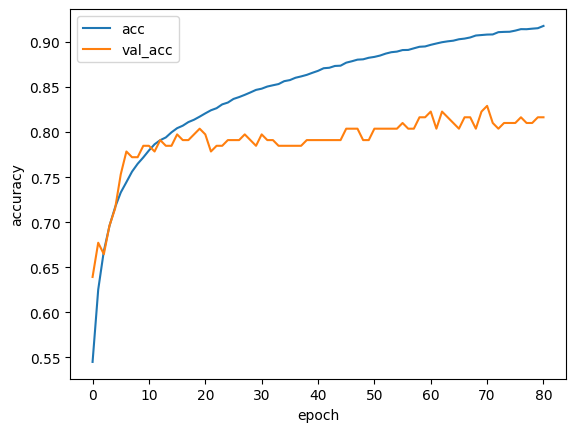

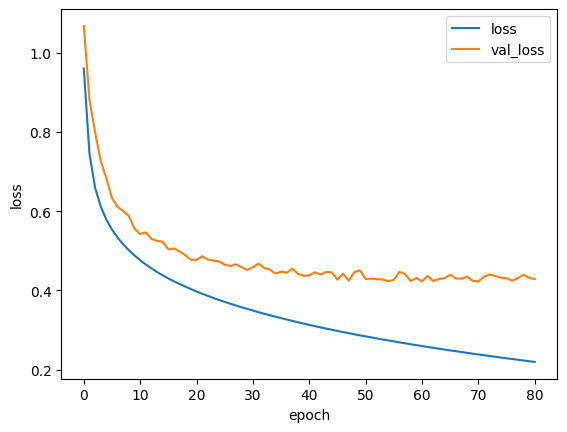

In [ ]:
# VGG-16 -GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])


# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("vgg16_model_1.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 9s 21ms/step - loss: 2.3139 - accuracy: 0.6523 - precision_9: 0.6523 - recall_9: 0.6523 - val_loss: 2.9596 - val_accuracy: 0.7025 - val_precision_9: 0.7025 - val_recall_9: 0.7025
Epoch 2/1000
420/420 [==============================] - 8s 19ms/step - loss: 1.1142 - accuracy: 0.7616 - precision_9: 0.7616 - recall_9: 0.7616 - val_loss: 2.3847 - val_accuracy: 0.7532 - val_precision_9: 0.7532 - val_recall_9: 0.7532
Epoch 3/1000
420/420 [==============================] - 8s 19ms/step - loss: 0.7468 - accuracy: 0.8130 - precision_9: 0.8130 - recall_9: 0.8130 - val_loss: 2.2313 - val_accuracy: 0.7405 - val_precision_9: 0.7405 - val_recall_9: 0.7405
Epoch 4/1000
420/420 [==============================] - 8s 19ms/step - loss: 0.5508 - accuracy: 0

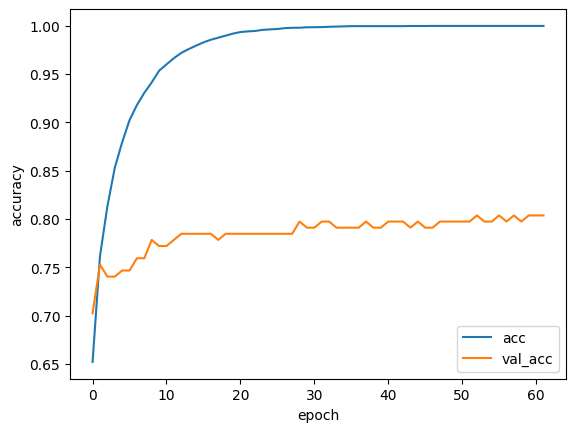

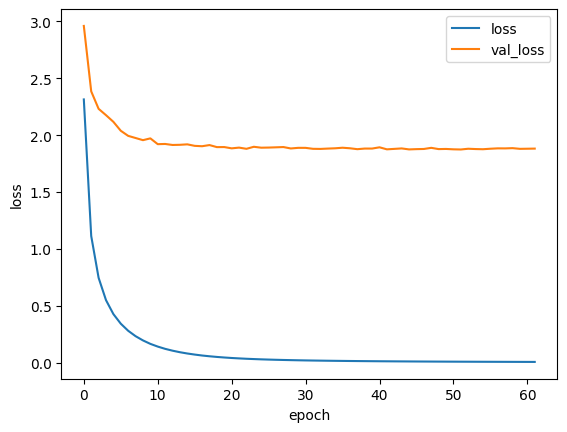

In [ ]:
# VGG-16 -Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])


# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("vgg16_model_2.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 299, 299, 3)
(158, 299, 299, 3)
Epoch 1/1000
420/420 [==============================] - 15s 25ms/step - loss: 1.9899 - accuracy: 0.5243 - precision_10: 0.5243 - recall_10: 0.5243 - val_loss: 1.4965 - val_accuracy: 0.5570 - val_precision_10: 0.5570 - val_recall_10: 0.5570
Epoch 2/1000
420/420 [==============================] - 9s 21ms/step - loss: 1.4121 - accuracy: 0.5493 - precision_10: 0.5493 - recall_10: 0.5493 - val_loss: 1.2880 - val_accuracy: 0.5633 - val_precision_10: 0.5633 - val_recall_10: 0.5633
Epoch 3/1000
420/420 [==============================] - 9s 21ms/step - loss: 1.2282 - accuracy: 0.5607 - precision_10: 0.5607 - recall_10: 0.5607 - val_loss: 1.2273 - val_accuracy: 0.5886 - val_precision_10: 0.5886 - val_recall_10: 0.5886
Epoch 4/1000
420/420 [==============================] - 9s 21ms/step - loss: 1.1192 

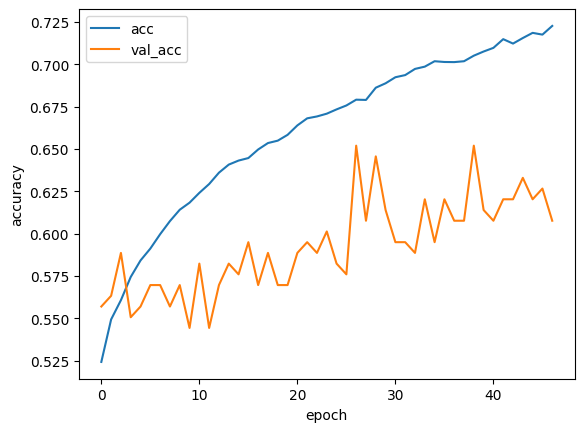

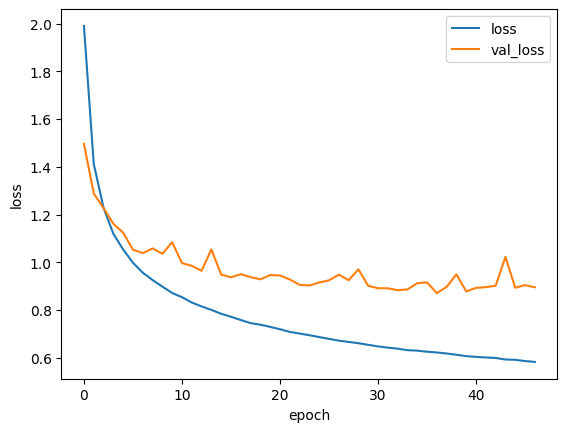

In [ ]:
# GoogleNet -1
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        # img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        img = cv2.resize(img, (299, 299))
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        # img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        img = cv2.resize(img, (299, 299))
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("GoogleNet_1.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 30s 46ms/step - loss: 0.7413 - accuracy: 0.5051 - precision_11: 0.5051 - recall_11: 0.5051 - val_loss: 0.7085 - val_accuracy: 0.6076 - val_precision_11: 0.6076 - val_recall_11: 0.6076
Epoch 2/1000
420/420 [==============================] - 16s 38ms/step - loss: 0.7290 - accuracy: 0.5100 - precision_11: 0.5100 - recall_11: 0.5100 - val_loss: 0.7005 - val_accuracy: 0.5886 - val_precision_11: 0.5886 - val_recall_11: 0.5886
Epoch 3/1000
420/420 [==============================] - 16s 38ms/step - loss: 0.7220 - accuracy: 0.5113 - precision_11: 0.5113 - recall_11: 0.5113 - val_loss: 0.6952 - val_accuracy: 0.5949 - val_precision_11: 0.5949 - val_recall_11: 0.5949
Epoch 4/1000
420/420 [==============================] - 16s 38ms/step - loss: 0.71

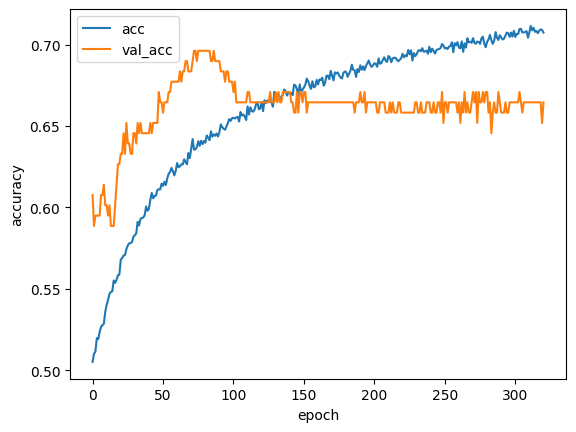

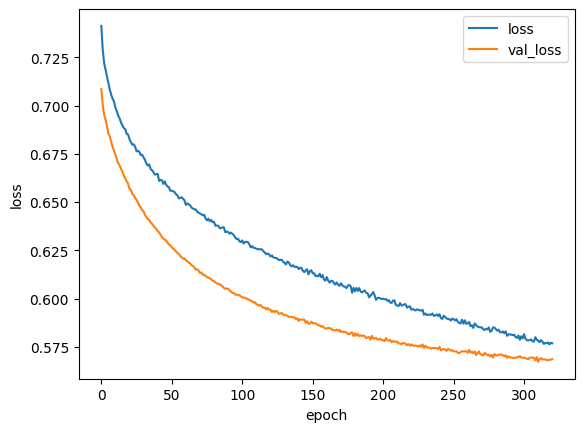

In [ ]:
# DenseNet201 -1

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("densenet201_1.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 12s 21ms/step - loss: 0.8973 - accuracy: 0.4757 - precision_12: 0.4757 - recall_12: 0.4757 - val_loss: 0.7232 - val_accuracy: 0.5127 - val_precision_12: 0.5127 - val_recall_12: 0.5127
Epoch 2/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.7936 - accuracy: 0.4638 - precision_12: 0.4638 - recall_12: 0.4638 - val_loss: 0.7138 - val_accuracy: 0.5443 - val_precision_12: 0.5443 - val_recall_12: 0.5443
Epoch 3/1000
420/420 [==============================] - 8s 18ms/step - loss: 0.7669 - accuracy: 0.4776 - precision_12: 0.4776 - recall_12: 0.4776 - val_loss: 0.6974 - val_accuracy: 0.5696 - val_precision_12: 0.5696 - val_recall_12: 0.5696
Epoch 4/1000
420/420 [==============================] - 8s 18ms/step - loss: 0.7463 

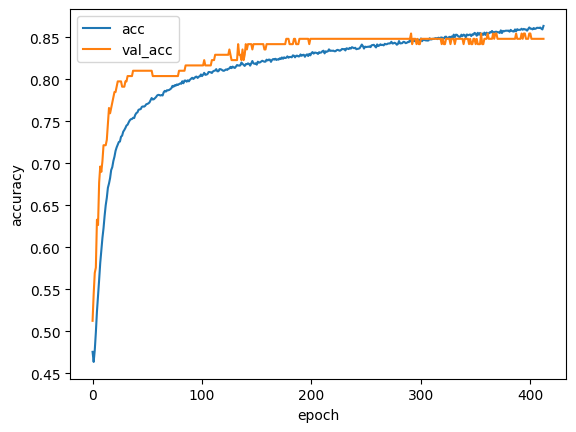

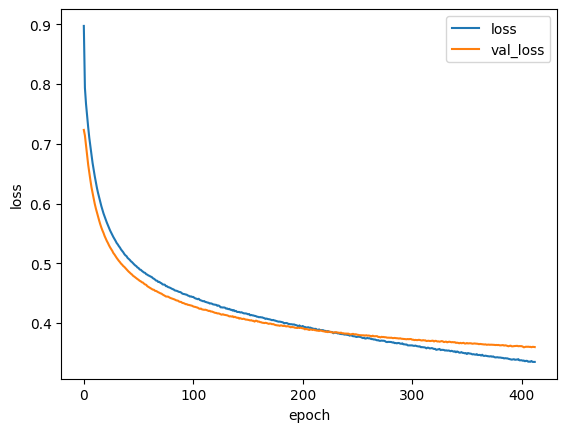

In [ ]:
# AlexNet -1
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=1,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("AlexNet_1.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 9s 14ms/step - loss: 0.7379 - accuracy: 0.4889 - precision_13: 0.4889 - recall_13: 0.4889 - val_loss: 0.7226 - val_accuracy: 0.5316 - val_precision_13: 0.5316 - val_recall_13: 0.5316
Epoch 2/1000
420/420 [==============================] - 5s 12ms/step - loss: 0.7296 - accuracy: 0.4993 - precision_13: 0.4993 - recall_13: 0.4993 - val_loss: 0.7098 - val_accuracy: 0.5253 - val_precision_13: 0.5253 - val_recall_13: 0.5253
Epoch 3/1000
420/420 [==============================] - 5s 12ms/step - loss: 0.7218 - accuracy: 0.5115 - precision_13: 0.5115 - recall_13: 0.5115 - val_loss: 0.7015 - val_accuracy: 0.5380 - val_precision_13: 0.5380 - val_recall_13: 0.5380
Epoch 4/1000
420/420 [==============================] - 5s 12ms/step - loss: 0.7167 -

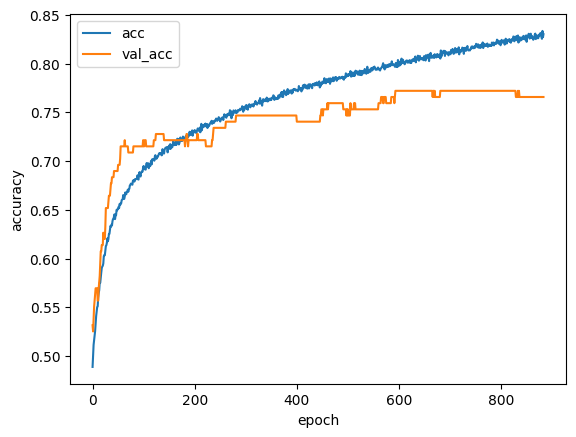

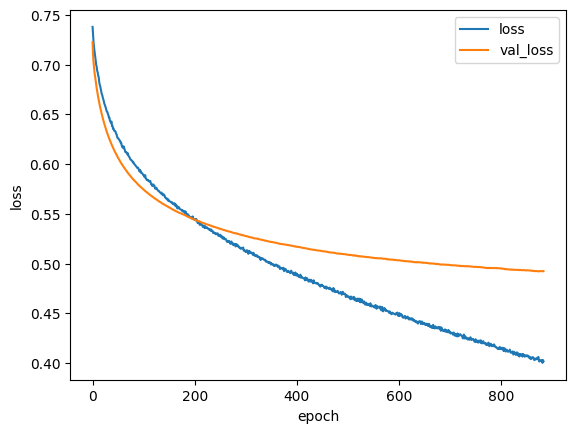

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-49923c5bc229>", line 144, in <cell line: 144>
    model.save("MobileNetV2_1.h5")
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5f.create
OSError: [Errno 107] Unable to 

In [ ]:
# MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=2,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("MobileNetV2_1.h5")

In [ ]:
# resnet50で特徴量抽出、SVMで分類
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
# ResNet50による特徴量抽出
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
X_train_resnet = base_model.predict(preprocess_input(X_train))
X_test_resnet = base_model.predict(preprocess_input(X_test))

# 抽出した特徴量を一次元に変換
X_train_features = X_train_resnet.reshape(X_train_resnet.shape[0], -1)
X_test_features = X_test_resnet.reshape(X_test_resnet.shape[0], -1)

# データのスケーリング
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# SVMモデルの訓練
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_features, np.argmax(y_train, axis=1))

# 予測
y_pred_train = svm_model.predict(X_train_features)
y_pred_test = svm_model.predict(X_test_features)

# 精度の評価
accuracy_train = accuracy_score(np.argmax(y_train, axis=1), y_pred_train)
accuracy_test = accuracy_score(np.argmax(y_test, axis=1), y_pred_test)
print(f'Training Accuracy: {accuracy_train}')
print(f'Validation Accuracy: {accuracy_test}')


# 混同行列（テストデータ）
print('Confusion Matrix for Test Data:')
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_test))

# モデル保存
from joblib import dump
dump(svm_model, 'svm_model.joblib')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-b034f9c63876>", line 28, in <cell line: 27>
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
OSError: [Errno 107] Transport endpoint is not connected: './train/pet'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_record

In [ ]:
resnet18

In [ ]:
!pip install tf-keras-resnet

ERROR: Could not find a version that satisfies the requirement tf-keras-resnet (from versions: none)
ERROR: No matching distribution found for tf-keras-resnet


In [ ]:
#resnet18 -1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tf_keras_resnet import ResnetBuilder
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResnetBuilder.build_resnet_18((224, 224, 3), len(name))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
# history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

history = model.fit(X_train, y_train, batch_size=32, epochs=3,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet18_model_1.h5")

ModuleNotFoundError: ignored

In [ ]:
#resnet18 -2 Batch Normalization（BN）と L2 正規化の組み込み
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tf_keras_resnet import ResnetBuilder
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResnetBuilder.build_resnet_18((224, 224, 3), len(name))

for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Dense層にL2正規化を追加
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
# BatchNormalization層を追加
x = BatchNormalization()(x)
predictions = Dense(len(name), activation='softmax', kernel_regularizer=l2(0.01))(x)


model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True, weight_decay=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# トレーニング
# history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

history = model.fit(X_train, y_train, batch_size=32, epochs=3,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet18_model_1.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/1000
420/420 [==============================] - 74s 142ms/step - loss: 0.8853 - accuracy: 0.6049 - precision: 0.6049 - recall: 0.6049 - val_loss: 0.9833 - val_accuracy: 0.6266 - val_precision: 0.6266 - val_recall: 0.6266
Epoch 2/1000
420/420 [==============================] - 57s 136ms/step - loss: 0.6734 - accuracy: 0.6672 - precision: 0.6672 - recall: 0.6672 - val_loss: 0.8678 - val_accuracy: 0.6456 - val_precision: 0.6456 - val_recall: 0.6456
Epoch 3/1000
420/420 [==============================] - 59s 141ms/step - loss: 0.6030 - accuracy: 0.7079 - precision: 0.7079 - recall: 0.7079 - val_loss: 0.8229 - val_accuracy: 0.6709 - val_precision: 0.6709 - val_recall: 0.6709
Epoch 4/1000
420/420 [============================

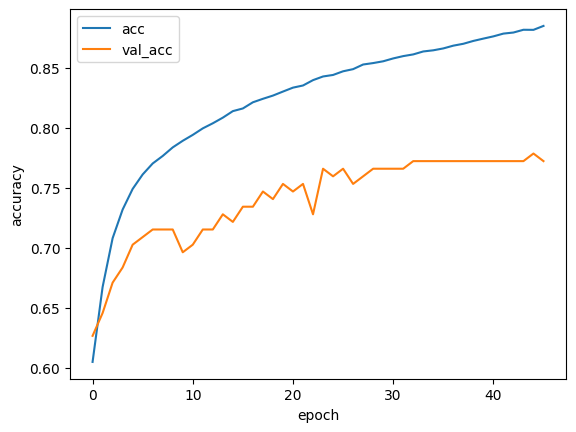

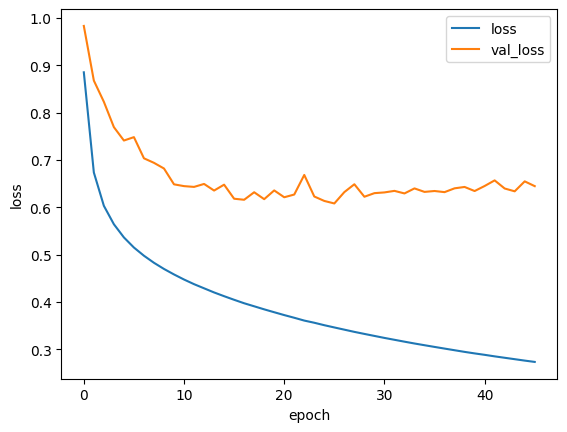

In [ ]:
# VGG-16 -GlobalAveragePooling2D -3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])


# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("vgg16_model_3.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 62s 145ms/step - loss: 2.3252 - accuracy: 0.6476 - precision_1: 0.6476 - recall_1: 0.6476 - val_loss: 2.6327 - val_accuracy: 0.7089 - val_precision_1: 0.7089 - val_recall_1: 0.7089
Epoch 2/1000
420/420 [==============================] - 61s 146ms/step - loss: 1.0693 - accuracy: 0.7715 - precision_1: 0.7715 - recall_1: 0.7715 - val_loss: 2.4581 - val_accuracy: 0.7405 - val_precision_1: 0.7405 - val_recall_1: 0.7405
Epoch 3/1000
420/420 [==============================] - 62s 147ms/step - loss: 0.7400 - accuracy: 0.8227 - precision_1: 0.8227 - recall_1: 0.8227 - val_loss: 2.0462 - val_accuracy: 0.7595 - val_precision_1: 0.7595 - val_recall_1: 0.7595
Epoch 4/1000
420/420 [==============================] - 62s 147ms/step - loss: 0.5590 - acc

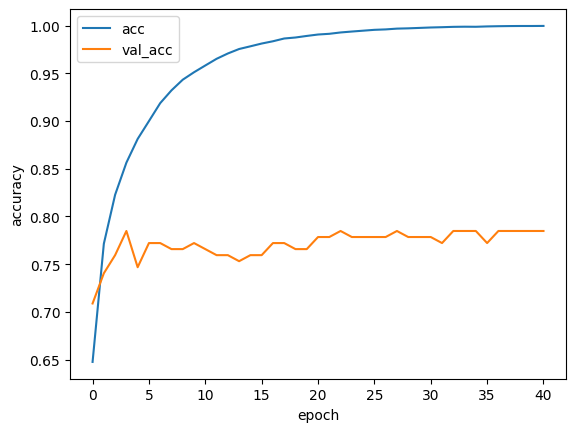

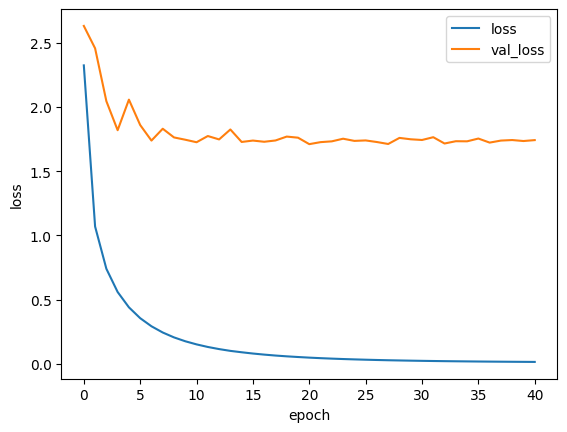

In [ ]:
# VGG-16 -Flatten -4
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])


# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("vgg16_model_4.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/1000
420/420 [==============================] - 46s 99ms/step - loss: 0.8230 - accuracy: 0.5100 - precision_2: 0.5100 - recall_2: 0.5100 - val_loss: 0.6896 - val_accuracy: 0.6013 - val_precision_2: 0.6013 - val_recall_2: 0.6013
Epoch 2/1000
420/420 [==============================] - 40s 94ms/step - loss: 0.7610 - accuracy: 0.5236 - precision_2: 0.5236 - recall_2: 0.5236 - val_loss: 0.6807 - val_accuracy: 0.5949 - val_precision_2: 0.5949 - val_recall_2: 0.5949
Epoch 3/1000
420/420 [==============================] - 40s 95ms/step - loss: 0.7394 - accuracy: 0.5347 - precision_2: 0.5347 - recall_2: 0.5347 - val_loss: 0.6630 - val_accuracy: 0.6139 - val_precision_2: 0.6139 - val_recall_2: 0.6139
Epoch 4/1000
420/420 [=======

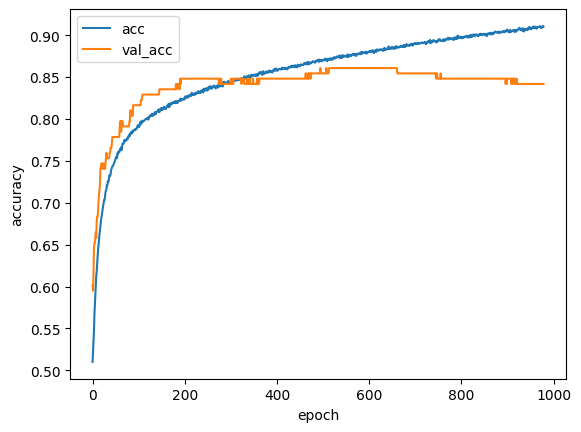

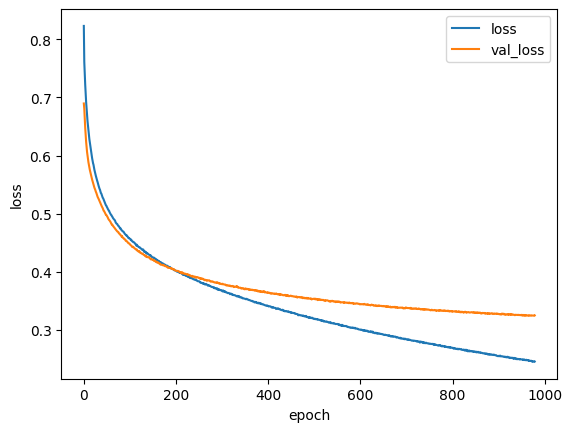

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a68ef8658d71>", line 144, in <cell line: 144>
    model.save("AlexNet_2.h5")
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5f.create
OSError: [Errno 107] Unable to creat

In [ ]:
# AlexNet -2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=1,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("AlexNet_2.h5")

In [ ]:
# GoogleNet -2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        # img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        img = cv2.resize(img, (299, 299))
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        # img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        img = cv2.resize(img, (299, 299))
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# history = model.fit(X_train, y_train, batch_size=32, epochs=3,
#                     validation_data=(X_test, y_test),
#                     callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("GoogleNet_2.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/1000
420/420 [==============================] - 23s 23ms/step - loss: 0.8093 - accuracy: 0.4911 - precision: 0.4911 - recall: 0.4911 - val_loss: 0.9067 - val_accuracy: 0.4937 - val_precision: 0.4937 - val_recall: 0.4937
Epoch 2/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.7592 - accuracy: 0.5106 - precision: 0.5106 - recall: 0.5106 - val_loss: 0.8530 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.7372 - accuracy: 0.5307 - precision: 0.5307 - recall: 0.5307 - val_loss: 0.8261 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/1000
420/420 [==============================] -

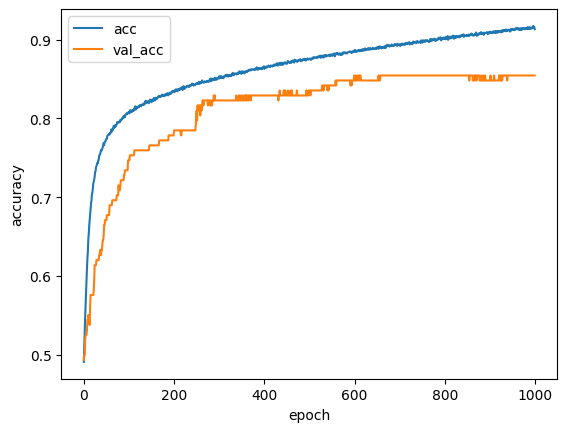

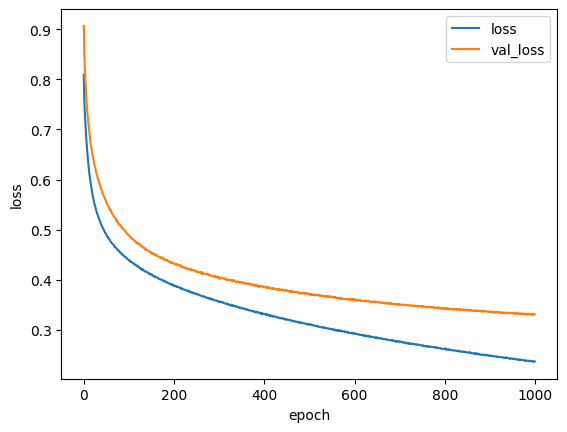

In [ ]:
# resnet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet50_model_5.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/1000
420/420 [==============================] - 23s 24ms/step - loss: 0.7885 - accuracy: 0.4926 - precision: 0.4926 - recall: 0.4926 - val_loss: 0.7640 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/1000
420/420 [==============================] - 8s 18ms/step - loss: 0.7548 - accuracy: 0.4862 - precision: 0.4862 - recall: 0.4862 - val_loss: 0.7361 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 3/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.7374 - accuracy: 0.4843 - precision: 0.4843 - recall: 0.4843 - val_loss: 0.7193 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 4/1000
420/420 [==============================] -

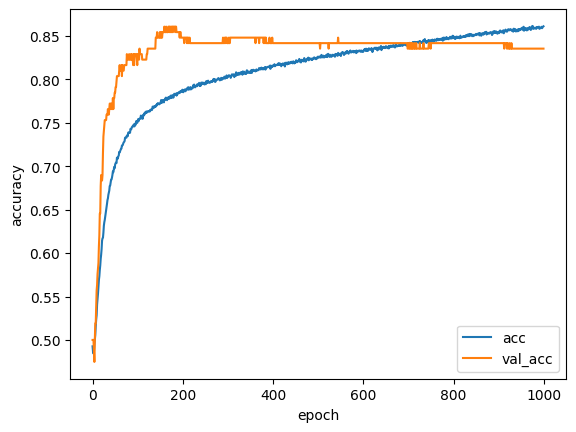

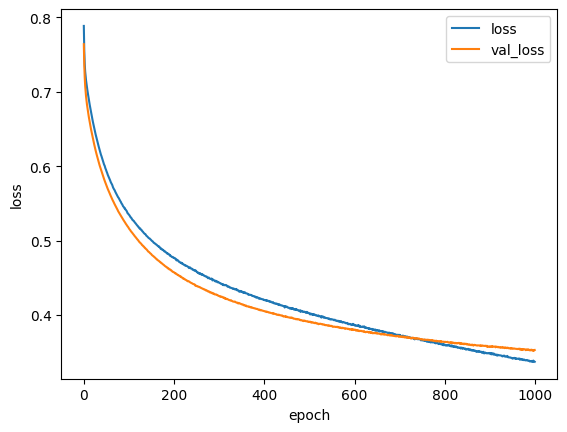

In [ ]:
# resnet50 -SE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# SEブロックを定義
def se_block(in_block, ch, rate=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//rate,activation='relu')(x)
    x = Dense(ch,activation='sigmoid') (x)
    # x = Reshape((1, 1, ch))(x)
    return multiply([in_block, x])

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = se_block(x, 2048, rate=16)  # SE block
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet50_SE_recall.h5")

pet's number of images(train) are: 6720
stray's number of images(train) are: 6720
pet's number of images(test) are: 80
stray's number of images(test) are: 80
(13438, 224, 224, 3)
(158, 224, 224, 3)
Epoch 1/1000
420/420 [==============================] - 12s 21ms/step - loss: 0.7541 - accuracy: 0.5070 - precision_1: 0.5070 - recall_1: 0.5070 - val_loss: 0.7015 - val_accuracy: 0.5443 - val_precision_1: 0.5443 - val_recall_1: 0.5443
Epoch 2/1000
420/420 [==============================] - 8s 18ms/step - loss: 0.7311 - accuracy: 0.5260 - precision_1: 0.5260 - recall_1: 0.5260 - val_loss: 0.6894 - val_accuracy: 0.6203 - val_precision_1: 0.6203 - val_recall_1: 0.6203
Epoch 3/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.7135 - accuracy: 0.5452 - precision_1: 0.5452 - recall_1: 0.5452 - val_loss: 0.6792 - val_accuracy: 0.6203 - val_precision_1: 0.6203 - val_recall_1: 0.6203
Epoch 4/1000
420/420 [==============================] - 7s 18ms/step - loss: 0.6954 - accuracy: 

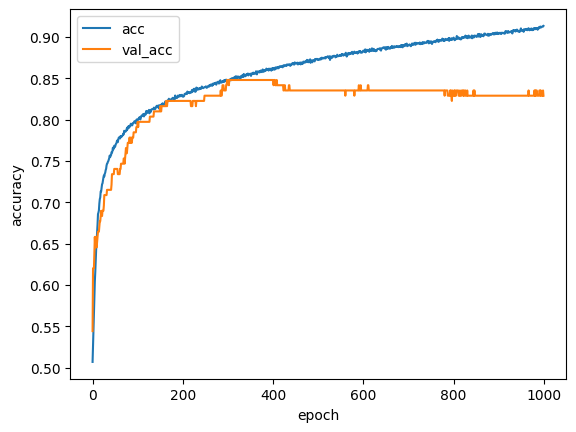

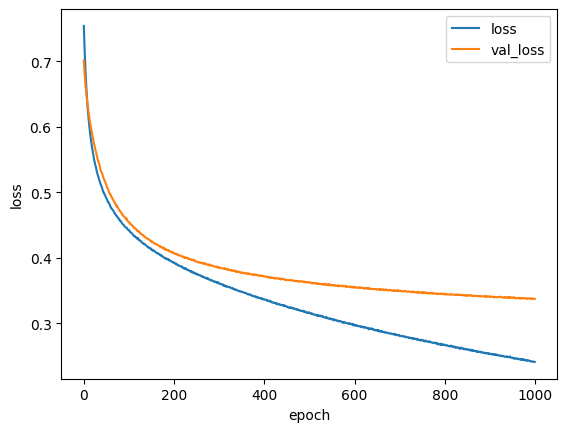

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-18cceeaff961>", line 142, in <cell line: 142>
    model.save("resnet50_epoch16_6.h5")
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 567, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/usr/local/lib/python3.10/dist-packages/h5py/_hl/files.py", line 237, in make_fid
    fid = h5f.create(name, h5f.ACC_TRUNC, fapl=fapl, fcpl=fcpl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 126, in h5py.h5f.create
OSError: [Errno 107] Unable

In [ ]:
# 学習エポック-16
# resnet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(name), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet50_epoch16_6.h5")

In [ ]:
# resnet50 -swish
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply, Lambda
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Swish活性化関数の定義
def swish(x, beta=1):
    return x * (1 / (1 + tf.math.exp(-beta * x)))

# SEブロック内でSwishを適用
def se_block(in_block, ch, rate=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//rate)(x)
    x = Lambda(swish)(x)  # ReLUをSwishに置き換え
    x = Dense(ch, activation='sigmoid')(x)
    return multiply([in_block, x])

# データ読み込み
name = ["pet", "stray"]
X_train, Y_train = [], []
X_test, Y_test = [], []

# ... （ここにデータロードのコードを挿入してください。上で記載しているのと同様のもの。） ...
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./train/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(train) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1): # 取得した画像数だけループを回す
        n=os.path.join("./train/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b]) #OpenCVは色をBGRの順で扱うが、通常はRGBの順で扱うので並び替える
        X_train.append(img) # 読み込んだ画像をX_trainに入れる
        Y_train.append(i) # ペットか野良かを表すラベルをY_trainに入れる


# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(name)):
    img_file_name_list = [f for f in os.listdir("./test/"+name[i]) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    print(name[i]+"'s number of images(test) are:", len(img_file_name_list))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+name[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        img = cv2.resize(img, (224, 224))  # 画像をリサイズ
        if img is None:
            print("Failed to open image file:", n)
            continue
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        X_test.append(img)
        # ラベルは整数値
        Y_test.append(i)

# 画像の形式をNumPyの配列に変換
X_train=np.array(X_train)
X_test=np.array(X_test)

# RGBチャンネルの並び替えと形状チェック
X_train = X_train[..., ::-1]
X_test = X_test[..., ::-1]
print(X_train.shape)  # 確認する
print(X_test.shape)  # 確認する

# ラベルをカテゴリー変数で変換
y_train = to_categorical(Y_train, len(name))
y_test = to_categorical(Y_test, len(name))

# モデル作成
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.save_weights('resnet50_base_model_weights.h5')
for layer in base_model.layers[:-5]:
    layer.trainable = False
x = base_model.output
x = se_block(x, 2048, rate=16)  # SE block
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = Lambda(swish)(x)  # ReLUをSwishに置き換え
predictions = Dense(len(name), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


# コンパイル
optimizer = legacy.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# トレーニング
history = model.fit(X_train, y_train, batch_size=32, epochs=1000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# 評価
score = model.evaluate(X_test, y_test, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# モデルによる予測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混同行列
cm = confusion_matrix(y_true, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred_classes, average=None)  # average=None: 各クラスごとの値を配列で返す
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_true, y_pred_classes, average=None)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f'F1-Score: {f1}')

# グラフ表示
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="loss", ls="-", marker="")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# モデル保存
model.save("resnet50_SE_recall.h5")

FileNotFoundError: ignored